# Exploring neural network modeling strategies

## Preprocessing the data

In [39]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [40]:
import os
import polars as pl
import numpy as np
from pathlib import Path
import kagglehub
import mlflow

from utils import (
    download_data,
)

from constants import (
    DATASET_PATH,
)

mlflow.set_tracking_uri("http://localhost:5000")

In [41]:
download_data()

data_path = Path(DATASET_PATH)

data_path

Kaggle credentials set.


PosixPath('data/problematic-internet-use')

In [42]:
train = pl.read_csv(data_path / 'train.csv')

### Dropping pre-label columns (i.e. columns used to build the final label `iis`)

In [43]:
pre_label = [
    'PCIAT-Season',
    'PCIAT-PCIAT_01',
    'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03',
    'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07',
    'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09',
    'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11',
    'PCIAT-PCIAT_12',
    'PCIAT-PCIAT_13',
    'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15',
    'PCIAT-PCIAT_16',
    'PCIAT-PCIAT_17',
    'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19',
    'PCIAT-PCIAT_20',
    'PCIAT-PCIAT_Total',
]

In [44]:
train = train.drop(pre_label)

In [45]:
features = train.columns[:-1]
label = train.columns[-1:]

X = train[features]
y = train[label]

### Droping the _season_ columns:

In [46]:
from polars import selectors as cs

X = X.select(~cs.ends_with("Season"))

X

id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
str,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
"""00008ff9""",5,0,51,16.877316,46.0,50.8,null,null,null,null,null,null,null,0,0,null,null,null,null,0,0,7.0,0,6.0,0,6.0,1,2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,null,null,null,null,3
"""000fd460""",9,0,null,14.03559,48.0,46.0,22.0,75,70,122,null,null,null,3,0,null,null,null,null,5,0,11.0,1,11.0,1,3.0,0,2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,null,2.34,46,64,0
"""00105258""",10,1,71,16.648696,56.5,75.6,null,65,94,117,5,7,33,20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.17,38,54,2
"""00115b9f""",9,0,71,18.292347,56.0,81.6,null,60,97,117,6,9,37,18,1,null,null,null,null,5,0,7.0,0,7.0,0,7.0,1,3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,null,2.451,31,45,0
"""0016bb22""",18,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.04,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ff8a2de4""",13,0,60,16.36246,59.5,82.4,null,71,70,104,null,null,null,16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,3,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,1,33.3709,17.9797,66.2889,29.779,52.832,null,3.26,35,50,1
"""ffa9794a""",10,0,null,18.764678,53.5,76.4,27.0,60,78,118,null,null,null,0,0,null,null,null,null,4,0,0.0,0,0.0,0,12.0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2.34,null,null,0
"""ffcd4dbd""",11,0,68,21.4415,60.0,109.8,null,79,99,116,null,null,null,15,1,18.5,2,15.8,2,0,0,10.0,1,10.0,1,14.0,1,2,4.41305,21.4438,1253.74,2005.99,20.4825,75.8033,14.8043,6.63952,33.9967,2,33.9805,21.3403,71.3903,28.7792,54.463,null,2.729,56,77,0


### Droping `id` column

In [47]:
X = X.drop(['id'])

features = X.columns

### Droping unlabeled data:

In [48]:
y.to_series().value_counts()

sii,count
i64,u32
null,1224
0,1594
2,378
1,730
3,34


In [49]:
data = pl.concat([X, y], how='horizontal')
data = data.lazy().filter(pl.col(label).is_not_null()).collect()

X = data[features]
y = data[label]

In [50]:
y.to_series().value_counts()

sii,count
i64,u32
2,378
3,34
0,1594
1,730


### Understanding the missing data

In [51]:
X.describe()

statistic,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2736.0,2736.0,2342.0,2527.0,2530.0,2572.0,483.0,2478.0,2486.0,2478.0,731.0,728.0,728.0,1919.0,1884.0,872.0,864.0,871.0,864.0,1909.0,1875.0,1911.0,1877.0,1913.0,1879.0,1919.0,1885.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,1813.0,363.0,1440.0,2527.0,2525.0,2654.0
"""null_count""",0.0,0.0,394.0,209.0,206.0,164.0,2253.0,258.0,250.0,258.0,2005.0,2008.0,2008.0,817.0,852.0,1864.0,1872.0,1865.0,1872.0,827.0,861.0,825.0,859.0,823.0,857.0,817.0,851.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,923.0,2373.0,1296.0,209.0,211.0,82.0
"""mean""",10.23867,0.364401,65.159266,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,5.001368,7.394231,27.656593,11.912976,0.524947,22.07797,1.820602,23.083639,1.887731,5.782609,0.3472,8.767975,0.636654,8.877888,0.63438,9.119567,0.772944,2.671263,6.954484,19.232347,1236.604226,2069.411478,20.781963,73.977613,14.992021,4.240327,15.827994,1.733591,33.134537,20.061121,67.02313,34.372294,53.9165,2.185758,2.590608,40.977839,57.647525,1.015072
"""std""",3.427982,0.48135,11.81105,4.909305,7.394938,43.353079,5.230213,13.790203,13.769816,17.221707,2.016711,3.180463,17.75642,11.979877,0.49951,10.484763,0.613854,10.517376,0.616601,7.441061,0.476207,3.289944,0.481091,3.320215,0.481732,2.954478,0.41904,1.030997,97.022087,4.9219,1960.147933,2966.4538,76.697505,208.781862,6.012465,6.538342,208.771419,0.671201,58.852697,73.538391,113.554916,87.917006,135.377293,0.815263,0.78661,10.231384,13.042815,1.080861
"""min""",5.0,0.0,25.0,0.0,36.0,0.0,19.0,11.0,27.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-7.78961,0.0482667,813.397,1073.45,1.78945,28.9004,7.86485,-194.163,-8745.08,1.0,17.845,4.63581,23.6201,11.3825,20.5892,0.66,0.58,17.0,38.0,0.0
"""25%""",8.0,0.0,59.0,15.780022,50.0,57.2,23.0,61.0,73.0,107.0,4.0,6.0,13.0,4.0,0.0,15.1,1.0,16.1,1.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2.0,2.9768,15.8576,1004.24,1606.28,11.0634,49.228,13.381,2.27349,8.42555,1.0,24.4088,12.9227,45.058,21.1244,35.7709,1.52,2.02,33.0,47.0,0.0
"""50%""",10.0,0.0,65.0,17.81901,55.0,75.8,26.0,68.0,81.0,114.0,5.0,7.0,28.0,10.0,1.0,19.4,2.0,20.8,2.0,3.0,0.0,9.0,1.0,9.0,1.0,9.0,1.0,3.0,3.93749,17.8506,1113.04,1862.15,15.7303,60.8162,14.0629,3.63948,15.7727,2.0,28.7659,16.2828,56.4291,27.1935,44.7213,2.08,2.55,39.0,55.0,1.0
"""75%""",12.0,1.0,75.0,21.173921,61.75,111.4,29.0,76.0,91.0,125.0,6.0,9.0,43.0,16.0,1.0,26.3,2.0,27.9,2.0,9.0,1.0,11.0,1.0,11.0,1.0,12.0,1.0,3.0,5.4625,21.206,1301.67,2213.17,24.6064,80.908,15.3716,5.88148,29.6452,2.0,35.1297,21.8522,75.8113,37.5047,59.6193,2.78,3.16,46.0,64.0,2.0
"""max""",22.0,1.0,95.0,46.102914,78.5,315.0,50.0,179.0,138.0,203.0,28.0,20.0,59.0,115.0,1.0,124.0,3.0,123.8,3.0,51.0,1.0,21.7,1.0,21.0,1.0,21.0,1.0,5.0,4115.36,48.3754,83152.2,124728.0,3233.0,8799.08,217.771,28.2515,129.226,3.0,2457.91,3108.17,4683.71,3607.69,5690.91,4.54,4.79,96.0,100.0,3.0


In [52]:
_, *not_null = X.describe().row(by_predicate=(pl.col("statistic") == "count"))
_, *null = X.describe().row(by_predicate=(pl.col("statistic") == "null_count"))

null_percentage = ['null_percentage', *((100 * np.array(null) / (np.array(null) + np.array(not_null))).round(decimals=2))]
null_percentage = pl.DataFrame({key: value for key, value in zip(X.describe().columns, null_percentage)})

null_percentage

statistic,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""null_percentage""",0.0,0.0,14.4,7.64,7.53,5.99,82.35,9.43,9.14,9.43,73.28,73.39,73.39,29.86,31.14,68.13,68.42,68.17,68.42,30.23,31.47,30.15,31.4,30.08,31.32,29.86,31.1,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,33.74,86.73,47.37,7.64,7.71,3.0


### Imputing missing data

There is a lot of missing data, let's use the [`KNNImputer` class](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill them (see [this guide](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/)):

In [53]:
size = X.height * X.width
missing = sum(X.null_count().row(0))

print(f'We have {size} total cells and {missing} missing cells ({100 * missing / size:.2f}% of data)')

We have 131328 total cells and 44814 missing cells (34.12% of data)


In [54]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
imputer.fit(X.to_numpy())
X_trans = imputer.transform(X.to_numpy())

Re-creating the `X` dataframes:

In [55]:
X = pl.DataFrame(schema=X.schema, data=X_trans)

In [56]:
size = X.height * X.width
missing = sum(X.null_count().row(0))

print(f'We have {size} total cells and {missing} missing cells ({100 * missing / size:.2f}% of data)')

We have 131328 total cells and 0 missing cells (0.00% of data)


In [57]:
X

Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday
i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
5,0,51,16.877316,46.0,50.8,22.2,63,85,110,3,4,36,0,0,12.3,1,12.16,1,0,0,7.0,0,6.0,0,6.0,1,2,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,1,24.4349,8.89536,38.9177,19.5413,32.6909,1.866,2.668,35,53,3
9,0,59,14.03559,48.0,46.0,22.0,75,70,122,5,9,21,3,0,19.5,1,19.86,1,5,0,11.0,1,11.0,1,3.0,0,2,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1,21.0352,14.974,39.4497,15.4107,27.0552,1.718,2.34,46,64,0
10,1,71,16.648696,56.5,75.6,26.2,65,94,117,5,7,33,20,1,10.2,1,14.7,2,7,1,10.0,1,10.0,1,5.0,0,3,3.776818,17.14786,1116.302,1942.924,15.32608,61.1641,13.69726,3.450578,15.1959,1,29.5544,16.2836,57.38728,28.28314,44.88046,1.778,2.17,38,54,2
9,0,71,18.292347,56.0,81.6,26.4,60,97,117,6,9,37,18,1,24.28,1,26.56,2,5,0,7.0,0,7.0,0,7.0,1,3,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,2,30.4041,16.779,58.9338,26.4798,45.9966,1.97,2.451,31,45,0
13,1,50,22.279952,59.5,112.2,27.0,60,73,102,4,6,39,12,0,16.5,2,17.9,2,6,0,10.0,1,11.0,1,8.0,0,2,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,2,32.9141,20.902,79.6982,35.3804,63.1265,1.47,4.11,40,56,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8,0,71,17.13981,52.5,67.2,25.0,60,65,112,5,8,34,0,0,10.98,1,11.52,1,0,0,8.0,1,10.0,1,12.0,1,3,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,1,25.7118,15.815,49.3301,20.2645,36.7181,1.41,3.44,41,58,2
7,1,61,13.927006,48.5,46.6,23.0,65,75,105,5,8,28,0,0,12.62,1,13.9,1,0,0,9.0,0,8.5,0,4.5,0,1,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,1,20.0572,15.14,42.8185,18.0937,30.0453,1.718,2.018,48,67,0
13,0,60,16.36246,59.5,82.4,26.8,71,70,104,5,9,28,16,0,18.0,1,19.9,2,10,1,8.0,1,9.0,1,12.0,1,3,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,1,33.3709,17.9797,66.2889,29.779,52.832,1.71,3.26,35,50,1


### Add _one-hot encodings_ for the categorical columns and drop them:

In [58]:
features_categorical = [
    'FGC-FGC_CU_Zone',
    'FGC-FGC_GSND_Zone',
    'FGC-FGC_GSD_Zone',
    'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL_Zone',
    'FGC-FGC_SRR_Zone',
    'FGC-FGC_TL_Zone',
    'BIA-BIA_Activity_Level_num',
    'BIA-BIA_Frame_num',
    'PreInt_EduHx-computerinternet_hoursday'
]

In [59]:
one_hot = X.select(pl.col(features_categorical)).to_dummies()
features_one_hot = one_hot.columns

X = pl.concat([X, one_hot], how='horizontal')
X = X.drop(features_categorical)

features = X.columns

In [60]:
X

Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,FGC-FGC_CU_Zone_0,FGC-FGC_CU_Zone_1,FGC-FGC_GSND_Zone_1,FGC-FGC_GSND_Zone_2,FGC-FGC_GSND_Zone_3,FGC-FGC_GSD_Zone_1,FGC-FGC_GSD_Zone_2,FGC-FGC_GSD_Zone_3,FGC-FGC_PU_Zone_0,FGC-FGC_PU_Zone_1,FGC-FGC_SRL_Zone_0,FGC-FGC_SRL_Zone_1,FGC-FGC_SRR_Zone_0,FGC-FGC_SRR_Zone_1,FGC-FGC_TL_Zone_0,FGC-FGC_TL_Zone_1,BIA-BIA_Activity_Level_num_1,BIA-BIA_Activity_Level_num_2,BIA-BIA_Activity_Level_num_3,BIA-BIA_Activity_Level_num_4,BIA-BIA_Activity_Level_num_5,BIA-BIA_Frame_num_1,BIA-BIA_Frame_num_2,BIA-BIA_Frame_num_3,PreInt_EduHx-computerinternet_hoursday_0,PreInt_EduHx-computerinternet_hoursday_1,PreInt_EduHx-computerinternet_hoursday_2,PreInt_EduHx-computerinternet_hoursday_3
i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
5,0,51,16.877316,46.0,50.8,22.2,63,85,110,3,4,36,0,12.3,12.16,0,7.0,6.0,6.0,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,24.4349,8.89536,38.9177,19.5413,32.6909,1.866,2.668,35,53,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
9,0,59,14.03559,48.0,46.0,22.0,75,70,122,5,9,21,3,19.5,19.86,5,11.0,11.0,3.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,21.0352,14.974,39.4497,15.4107,27.0552,1.718,2.34,46,64,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0
10,1,71,16.648696,56.5,75.6,26.2,65,94,117,5,7,33,20,10.2,14.7,7,10.0,10.0,5.0,3.776818,17.14786,1116.302,1942.924,15.32608,61.1641,13.69726,3.450578,15.1959,29.5544,16.2836,57.38728,28.28314,44.88046,1.778,2.17,38,54,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0
9,0,71,18.292347,56.0,81.6,26.4,60,97,117,6,9,37,18,24.28,26.56,5,7.0,7.0,7.0,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,30.4041,16.779,58.9338,26.4798,45.9966,1.97,2.451,31,45,0,1,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
13,1,50,22.279952,59.5,112.2,27.0,60,73,102,4,6,39,12,16.5,17.9,6,10.0,11.0,8.0,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,32.9141,20.902,79.6982,35.3804,63.1265,1.47,4.11,40,56,1,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8,0,71,17.13981,52.5,67.2,25.0,60,65,112,5,8,34,0,10.98,11.52,0,8.0,10.0,12.0,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,25.7118,15.815,49.3301,20.2645,36.7181,1.41,3.44,41,58,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
7,1,61,13.927006,48.5,46.6,23.0,65,75,105,5,8,28,0,12.62,13.9,0,9.0,8.5,4.5,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,20.0572,15.14,42.8185,18.0937,30.0453,1.718,2.018,48,67,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
13,0,60,16.36246,59.5,82.4,26.8,71,70,104,5,9,28,16,18.0,19.9,10,8.0,9.0,12.0,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,33.3709,17.9797,66.2889,29.779,52.832,1.71,3.26,35,50,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0


### One-hot encoding the labels

In [61]:
y = y.to_dummies()
y

sii_0,sii_1,sii_2,sii_3
u8,u8,u8,u8
0,0,1,0
1,0,0,0
1,0,0,0
0,1,0,0
0,1,0,0
…,…,…,…
1,0,0,0
0,1,0,0
0,1,0,0


### Checking for correlated features

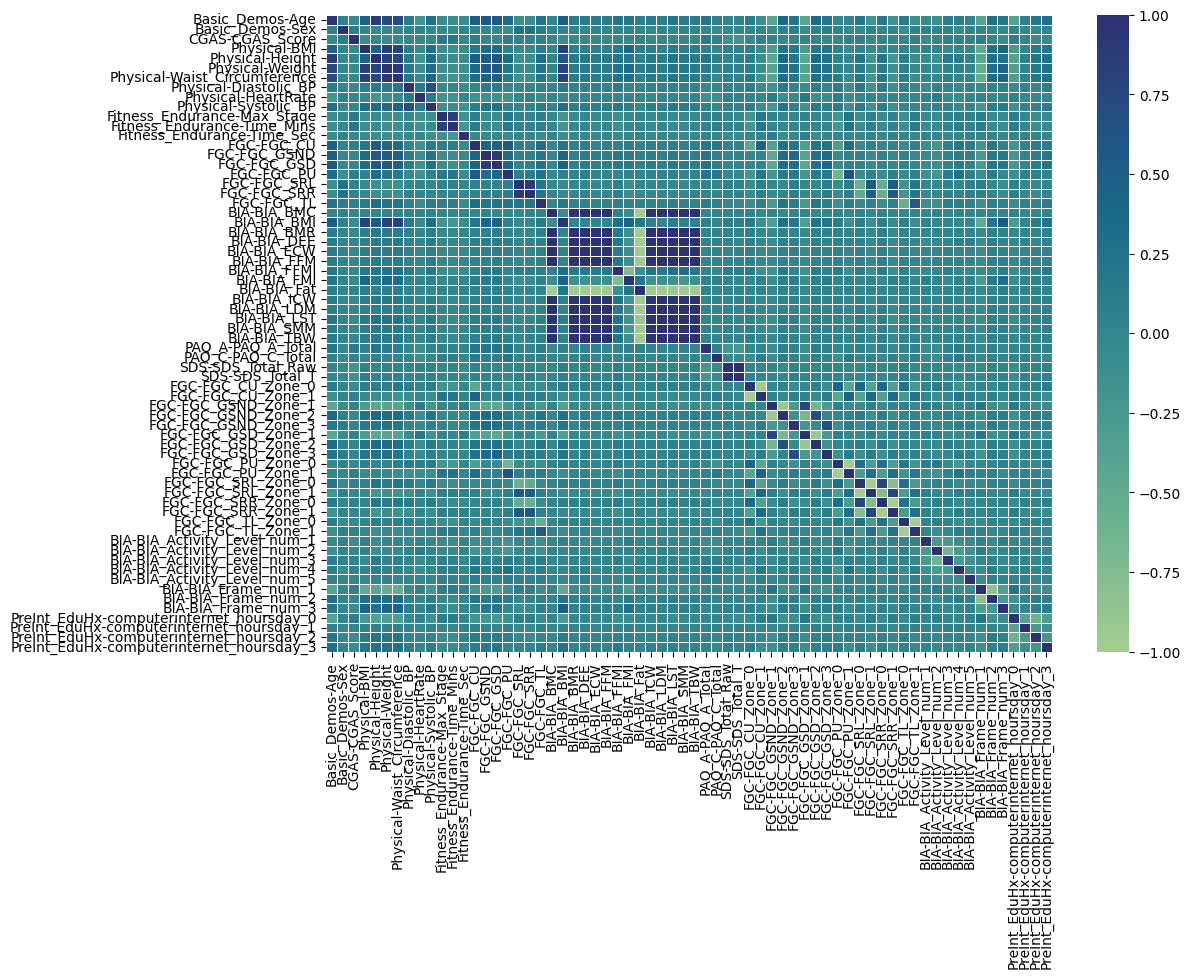

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

dim = (11.7, 8.27)
fig, ax = plt.subplots(figsize = dim)

ax = sns.heatmap(
    X.corr(),
    linewidth=0.5,
    cmap='crest',
    xticklabels=X.columns, yticklabels=X.columns)
plt.show()

In [63]:
correlation_threshold = .95
X_corr = X.corr()
corr_var_indexes = [
    {i, j} for i in range(X_corr.height) for j in range(X_corr.width)
    if abs(X_corr[i, j]) > correlation_threshold 
    and i != j
]
corr_var_indexes = list({frozenset(i) for i in corr_var_indexes})

# Display the results
for row, col in corr_var_indexes:
    print(f"({X_corr.columns[row]}, '{X_corr.columns[col]}')")

(BIA-BIA_TBW, 'BIA-BIA_LST')
(BIA-BIA_BMR, 'BIA-BIA_LDM')
(FGC-FGC_TL_Zone_0, 'FGC-FGC_TL_Zone_1')
(BIA-BIA_FFM, 'BIA-BIA_Fat')
(BIA-BIA_FFM, 'BIA-BIA_BMR')
(BIA-BIA_SMM, 'BIA-BIA_LDM')
(BIA-BIA_ICW, 'BIA-BIA_LST')
(BIA-BIA_BMC, 'BIA-BIA_Fat')
(FGC-FGC_SRL_Zone_0, 'FGC-FGC_SRL_Zone_1')
(BIA-BIA_SMM, 'BIA-BIA_BMR')
(BIA-BIA_ECW, 'BIA-BIA_LDM')
(BIA-BIA_Fat, 'BIA-BIA_BMR')
(BIA-BIA_SMM, 'BIA-BIA_DEE')
(BIA-BIA_TBW, 'BIA-BIA_Fat')
(BIA-BIA_SMM, 'BIA-BIA_TBW')
(BIA-BIA_ICW, 'BIA-BIA_LDM')
(BIA-BIA_ECW, 'BIA-BIA_BMR')
(BIA-BIA_Fat, 'BIA-BIA_LDM')
(BIA-BIA_ECW, 'BIA-BIA_TBW')
(BIA-BIA_FFM, 'BIA-BIA_DEE')
(FGC-FGC_PU_Zone_0, 'FGC-FGC_PU_Zone_1')
(BIA-BIA_BMC, 'BIA-BIA_LDM')
(BIA-BIA_ECW, 'BIA-BIA_BMC')
(BIA-BIA_SMM, 'BIA-BIA_FFM')
(BIA-BIA_BMR, 'BIA-BIA_DEE')
(BIA-BIA_TBW, 'BIA-BIA_ICW')
(BIA-BIA_BMR, 'BIA-BIA_LST')
(BIA-BIA_FFM, 'BIA-BIA_LDM')
(BIA-BIA_TBW, 'BIA-BIA_BMC')
(BIA-BIA_SMM, 'BIA-BIA_BMC')
(BIA-BIA_TBW, 'BIA-BIA_DEE')
(BIA-BIA_ECW, 'BIA-BIA_FFM')
(BIA-BIA_FFM, 'BIA-BIA_ICW')
(BIA-

### Scaling the data

In [64]:
X

Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,FGC-FGC_CU_Zone_0,FGC-FGC_CU_Zone_1,FGC-FGC_GSND_Zone_1,FGC-FGC_GSND_Zone_2,FGC-FGC_GSND_Zone_3,FGC-FGC_GSD_Zone_1,FGC-FGC_GSD_Zone_2,FGC-FGC_GSD_Zone_3,FGC-FGC_PU_Zone_0,FGC-FGC_PU_Zone_1,FGC-FGC_SRL_Zone_0,FGC-FGC_SRL_Zone_1,FGC-FGC_SRR_Zone_0,FGC-FGC_SRR_Zone_1,FGC-FGC_TL_Zone_0,FGC-FGC_TL_Zone_1,BIA-BIA_Activity_Level_num_1,BIA-BIA_Activity_Level_num_2,BIA-BIA_Activity_Level_num_3,BIA-BIA_Activity_Level_num_4,BIA-BIA_Activity_Level_num_5,BIA-BIA_Frame_num_1,BIA-BIA_Frame_num_2,BIA-BIA_Frame_num_3,PreInt_EduHx-computerinternet_hoursday_0,PreInt_EduHx-computerinternet_hoursday_1,PreInt_EduHx-computerinternet_hoursday_2,PreInt_EduHx-computerinternet_hoursday_3
i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
5,0,51,16.877316,46.0,50.8,22.2,63,85,110,3,4,36,0,12.3,12.16,0,7.0,6.0,6.0,2.66855,16.8792,932.498,1492.0,8.25598,41.5862,13.8177,3.06143,9.21377,24.4349,8.89536,38.9177,19.5413,32.6909,1.866,2.668,35,53,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
9,0,59,14.03559,48.0,46.0,22.0,75,70,122,5,9,21,3,19.5,19.86,5,11.0,11.0,3.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,21.0352,14.974,39.4497,15.4107,27.0552,1.718,2.34,46,64,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0
10,1,71,16.648696,56.5,75.6,26.2,65,94,117,5,7,33,20,10.2,14.7,7,10.0,10.0,5.0,3.776818,17.14786,1116.302,1942.924,15.32608,61.1641,13.69726,3.450578,15.1959,29.5544,16.2836,57.38728,28.28314,44.88046,1.778,2.17,38,54,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0
9,0,71,18.292347,56.0,81.6,26.4,60,97,117,6,9,37,18,24.28,26.56,5,7.0,7.0,7.0,3.84191,18.2943,1131.43,1923.44,15.5925,62.7757,14.074,4.22033,18.8243,30.4041,16.779,58.9338,26.4798,45.9966,1.97,2.451,31,45,0,1,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
13,1,50,22.279952,59.5,112.2,27.0,60,73,102,4,6,39,12,16.5,17.9,6,10.0,11.0,8.0,4.33036,30.1865,1330.97,1996.45,30.2124,84.0285,16.6877,13.4988,67.9715,32.9141,20.902,79.6982,35.3804,63.1265,1.47,4.11,40,56,1,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8,0,71,17.13981,52.5,67.2,25.0,60,65,112,5,8,34,0,10.98,11.52,0,8.0,10.0,12.0,3.20303,17.1417,1035.27,1759.96,11.0063,52.5331,13.4004,3.7413,14.6669,25.7118,15.815,49.3301,20.2645,36.7181,1.41,3.44,41,58,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0
7,1,61,13.927006,48.5,46.6,23.0,65,75,105,5,8,28,0,12.62,13.9,0,9.0,8.5,4.5,2.3668,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.4147,20.0572,15.14,42.8185,18.0937,30.0453,1.718,2.018,48,67,1,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
13,0,60,16.36246,59.5,82.4,26.8,71,70,104,5,9,28,16,18.0,19.9,10,8.0,9.0,12.0,4.52277,16.3642,1206.88,2051.7,19.4611,70.8117,14.0629,2.30138,11.5883,33.3709,17.9797,66.2889,29.779,52.832,1.71,3.26,35,50,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0


In [65]:
features_continuous = [feat for feat in features if feat not in features_one_hot]

features_continuous

['Basic_Demos-Age',
 'Basic_Demos-Sex',
 'CGAS-CGAS_Score',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'FGC-FGC_CU',
 'FGC-FGC_GSND',
 'FGC-FGC_GSD',
 'FGC-FGC_PU',
 'FGC-FGC_SRL',
 'FGC-FGC_SRR',
 'FGC-FGC_TL',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'PAQ_A-PAQ_A_Total',
 'PAQ_C-PAQ_C_Total',
 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T']

In [66]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler(feature_range = (-1, 1))

# Fit and transform the features
X_scaled = scaler.fit_transform(X[features_continuous])
X_continuous = pl.DataFrame(X_scaled, schema = features_continuous)

In [67]:
X = pl.concat([X_continuous, X[features_one_hot]], how = "horizontal")

X

Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_GSND,FGC-FGC_GSD,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,FGC-FGC_CU_Zone_0,FGC-FGC_CU_Zone_1,FGC-FGC_GSND_Zone_1,FGC-FGC_GSND_Zone_2,FGC-FGC_GSND_Zone_3,FGC-FGC_GSD_Zone_1,FGC-FGC_GSD_Zone_2,FGC-FGC_GSD_Zone_3,FGC-FGC_PU_Zone_0,FGC-FGC_PU_Zone_1,FGC-FGC_SRL_Zone_0,FGC-FGC_SRL_Zone_1,FGC-FGC_SRR_Zone_0,FGC-FGC_SRR_Zone_1,FGC-FGC_TL_Zone_0,FGC-FGC_TL_Zone_1,BIA-BIA_Activity_Level_num_1,BIA-BIA_Activity_Level_num_2,BIA-BIA_Activity_Level_num_3,BIA-BIA_Activity_Level_num_4,BIA-BIA_Activity_Level_num_5,BIA-BIA_Frame_num_1,BIA-BIA_Frame_num_2,BIA-BIA_Frame_num_3,PreInt_EduHx-computerinternet_hoursday_0,PreInt_EduHx-computerinternet_hoursday_1,PreInt_EduHx-computerinternet_hoursday_2,PreInt_EduHx-computerinternet_hoursday_3
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
-1.0,-1.0,-0.257143,-0.267842,-0.529412,-0.67746,-0.793548,-0.380952,0.045045,-0.207792,-0.785714,-0.6,0.220339,-1.0,-0.801613,-0.803554,-1.0,-0.354839,-0.428571,-0.428571,-0.994927,-0.303458,-0.997107,-0.99323,-0.995997,-0.997107,-0.943281,0.773485,0.972953,-0.994599,-0.997255,-0.993435,-0.995463,-0.995732,-0.378351,-0.008076,-0.544304,-0.516129,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
-0.529412,-1.0,-0.028571,-0.391119,-0.435294,-0.707937,-0.806452,-0.238095,-0.225225,-0.051948,-0.642857,-0.1,-0.288136,-0.947826,-0.685484,-0.67916,-0.803922,0.013825,0.047619,-0.714286,-0.99497,-0.421077,-0.997006,-0.993123,-0.997381,-0.997006,-0.952736,0.756852,0.971771,-0.997385,-0.993338,-0.993206,-0.99776,-0.997719,-0.454639,-0.163895,-0.265823,-0.16129,1,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0
-0.411765,1.0,0.314286,-0.277759,-0.035294,-0.52,-0.535484,-0.357143,0.207207,-0.116883,-0.642857,-0.3,0.118644,-0.652174,-0.835484,-0.76252,-0.72549,-0.078341,-0.047619,-0.52381,-0.99439,-0.29234,-0.992642,-0.985937,-0.991621,-0.992642,-0.944428,0.776985,0.974301,-0.990402,-0.992494,-0.985508,-0.990601,-0.991432,-0.423711,-0.244656,-0.468354,-0.483871,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0
-0.529412,-1.0,0.314286,-0.206456,-0.058824,-0.481905,-0.522581,-0.416667,0.261261,-0.116883,-0.571429,-0.1,0.254237,-0.686957,-0.608387,-0.570921,-0.803922,-0.354839,-0.333333,-0.333333,-0.994358,-0.244895,-0.992275,-0.986252,-0.991456,-0.992275,-0.940839,0.783906,0.975119,-0.989706,-0.992175,-0.984844,-0.991604,-0.991038,-0.324742,-0.111164,-0.64557,-0.774194,0,1,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
-0.058824,1.0,-0.285714,-0.033469,0.105882,-0.287619,-0.483871,-0.416667,-0.171171,-0.311688,-0.714286,-0.4,0.322034,-0.791304,-0.733871,-0.710824,-0.764706,-0.078341,0.047619,-0.238095,-0.994121,0.247259,-0.987428,-0.985071,-0.982407,-0.987428,-0.915935,0.86734,0.986195,-0.987649,-0.989518,-0.975933,-0.986654,-0.984997,-0.582474,0.67696,-0.417722,-0.419355,1,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.647059,-1.0,0.314286,-0.256454,-0.223529,-0.573333,-0.612903,-0.416667,-0.315315,-0.181818,-0.642857,-0.2,0.152542,-1.0,-0.822903,-0.813893,-1.0,-0.262673,-0.047619,0.142857,-0.994668,-0.292595,-0.994611,-0.988896,-0.994295,-0.994611,-0.947257,0.779599,0.974182,-0.993552,-0.992796,-0.988966,-0.99506,

### Balancing the data

In [68]:
y.sum()

sii_0,sii_1,sii_2,sii_3
i64,i64,i64,i64
1594,730,378,34


In [69]:
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

X_over, y_over = SMOTE().fit_resample(X.to_numpy(), y.to_numpy())

In [70]:
y = pl.DataFrame(y_over, schema = y.columns)
X = pl.DataFrame(X_over, schema = X.columns)

In [71]:
y.sum()

sii_0,sii_1,sii_2,sii_3
i64,i64,i64,i64
1594,1594,1594,1594


## Neural Network training

In [72]:
experiment_name = "all numerical + categorical one-hot encoded without season feats in labeled data nn"
features = X.columns

assert experiment_name
assert features

In [73]:
from sklearn.model_selection import train_test_split

train_fraction = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (1 - train_fraction), shuffle = True)

In [114]:
import os

os.environ["KERAS_BACKEND"] = "torch"

import torch
import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam

/home/fbaltor/kaggle/problematic-internet-use/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3514 - loss: 1.2502 - val_accuracy: 0.5729 - val_loss: 0.9490
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5592 - loss: 0.9234 - val_accuracy: 0.5363 - val_loss: 1.0291
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6121 - loss: 0.8150 - val_accuracy: 0.6492 - val_loss: 0.7608
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6534 - loss: 0.7121 - val_accuracy: 0.6550 - val_loss: 0.7116
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6606 - loss: 0.6997 - val_accuracy: 0.6712 - val_loss: 0.7067
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6774 - loss: 0.6812 - val_accuracy: 0.6801 - val_loss: 0.6929
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6983 - loss: 0.6535 - val_accuracy: 0.6827 - val_loss: 0.7166
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7311 - loss: 0.6193 - val_accuracy: 0.

2024/10/19 18:06:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/19 18:06:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/19 18:06:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-bird-952 at: http://localhost:5000/#/experiments/0/runs/1a5df9b95c3549cbb58a42ea630b3922.
2024/10/19 18:06:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


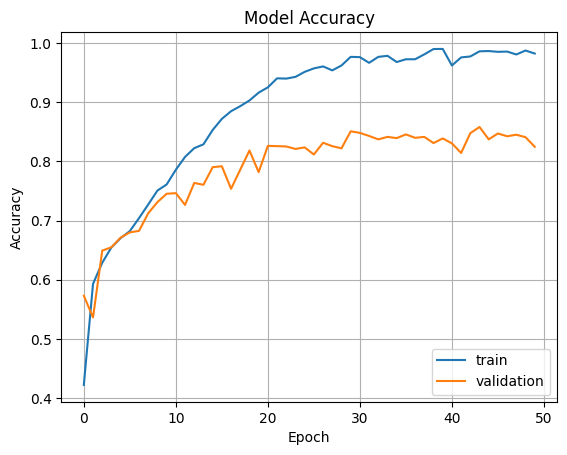

In [115]:
keras.backend.clear_session()

model = Sequential()
model.add(Dense(512, input_dim = X_train.width, activation='relu')),
model.add(Dense(256, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(64, activation='relu')),
model.add(Dense(32, activation='relu')),
model.add(Dense(16, activation='relu')),
model.add(Dense(8, activation='relu')),
model.add(Dense(y.width, activation='softmax'))

optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

experiment_metadata = {
    "model_features": features,
    "model_type": model.__class__.__name__,
}

EPOCHS = 50
BATCH_SIZE = 32

with mlflow.start_run() as run:
    history = model.fit(
        X_train.to_numpy(), 
        y_train.to_numpy(), 
        epochs = EPOCHS, 
        batch_size = BATCH_SIZE, 
        validation_data = (X_test.to_numpy(), y_test.to_numpy()),
        callbacks=[mlflow.keras.MlflowCallback(run)]
    )
    fig, ax = plt.subplots()
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'validation'], loc='lower right')
    ax.grid()
    mlflow.log_figure(fig, "training.png")
    mlflow.log_dict(experiment_metadata, "metadata.json")
    mlflow.keras.log_model(model, "model")

### Evaluation against `y_test` with quadratic weighted kappa score

In [108]:
from sklearn.metrics import cohen_kappa_score


y_pred = np.argmax(model(X_test).detach().numpy(), axis=1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

score = float(cohen_kappa_score(y_pred, y_true, weights='quadratic'))

score

0.8986417560258033